In [1]:
from transformers import GPT2Model, GPT2Tokenizer
import pandas as pd
import numpy as np
import torch
from vector_embedding import get_word_embeddings, calculate_similarity
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from IPython import display

/Users/tianyuwu/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def similarity(sentence, word1, word2, tokenizer, model, function = "cosine", layers = 8):
    embedding1, embedding2 = get_word_embeddings(sentence, word1, word2, tokenizer, model)
    return calculate_similarity(embedding1, embedding2,
        similarity_function = function,
        layers = layers)

In [3]:
# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2', output_hidden_states=True)

tokenizer_config.json: 100%|██████████| 26.0/26.0 [00:00<00:00, 76.3kB/s]
vocab.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 11.2MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 15.6MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 34.4MB/s]
config.json: 100%|██████████| 665/665 [00:00<00:00, 7.73MB/s]
model.safetensors: 100%|██████████| 548M/548M [00:09<00:00, 55.6MB/s] 


## ON 4000 pairs

In [4]:
df = pd.read_csv("data/4000_word_pairs.csv", index_col = "rank")
df.head()

,lemma,PoS,freq,synonym,synset,random
rank,,,,,,
26,say,v,4096416,tell,Synset('order.v.01'),blanket
31,go,v,3546732,start,Synset('start.v.09'),blank
34,get,v,3347615,acquire,Synset('get.v.01'),overhaul
39,know,v,2761628,recognise,Synset('acknowledge.v.06'),chisel
50,make,v,2290830,get,Synset('make.v.02'),tickle


In [5]:
df.isna().sum().sum()

0

In [6]:
PoS_map = {
    "n" : "nouns",
    "v" : "verbs",
    "a" : "adjectives",
    "r" : "adverbs"
}

In [8]:
df["random_similarity_left"] = None
df["random_similarity_right"] = None

In [9]:
for idx, row in df.iterrows():
    if row["random_similarity_right"] is not None:

        continue
    pos = PoS_map[row["PoS"]]
    word1 = row["lemma"]
    word2 = row["random"]

    sentence = "What is the similarity between the two {0}: {1} and {2}?".format(pos, word1, word2)
    df.loc[idx, "random_similarity_left"] = similarity(sentence, word1, word2, tokenizer, model)

    sentence = "What is the similarity between the two {0}: {1} and {2}?".format(pos, word2, word1)
    df.loc[idx, "random_similarity_right"] = similarity(sentence, word1, word2, tokenizer, model)
    print('{:.2%}'.format(idx/5050))
    display.clear_output(wait=True)

100.00%


In [10]:
df

,lemma,PoS,freq,synonym,synset,random,random_similarity_left,random_similarity_right
rank,,,,,,,,
26,say,v,4096416,tell,Synset('order.v.01'),blanket,0.612346,0.621714
31,go,v,3546732,start,Synset('start.v.09'),blank,0.592116,0.595401
34,get,v,3347615,acquire,Synset('get.v.01'),overhaul,0.672227,0.664227
39,know,v,2761628,recognise,Synset('acknowledge.v.06'),chisel,0.694732,0.695436
50,make,v,2290830,get,Synset('make.v.02'),tickle,0.678154,0.688789
...,...,...,...,...,...,...,...,...
5045,hammer,n,11886,mallet,Synset('mallet.n.02'),pavan,0.665129,0.671332
5047,persist,v,11880,remain,Synset('persist.v.03'),quest,0.701937,0.701642
5048,wheat,n,11877,straw,Synset('pale_yellow.n.01'),split,0.61535,0.601472


In [15]:
df["synonym_similarity"] = (df["synonym_similarity_left"] + df["synonym_similarity_right"]) / 2

In [27]:
df["random_similarity"] = (df["random_similarity_left"] + df["random_similarity_right"]) / 2

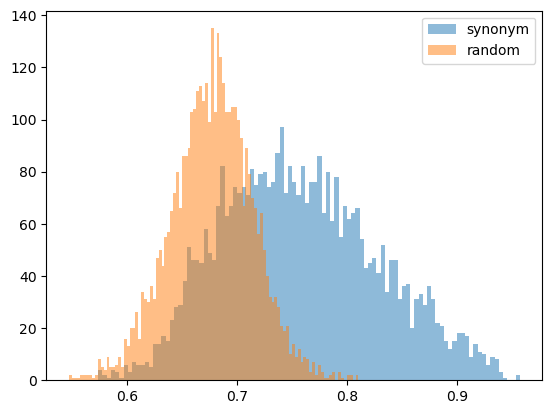

In [4]:
plt.hist(df["synonym_similarity"], bins = 100, alpha = 0.5, label="synonym")
plt.hist(df["random_similarity"], bins = 100, alpha = 0.5, label="random")
plt.legend()
plt.show()

In [32]:
# df.to_csv("data/4000_complete_data.csv")

## ON 464 pairs

In [23]:
df = pd.read_csv("data/464_synonym_raw.csv")
df = df.rename(columns={"Word1": "word1", "Word2": "word2", "Grand Mean": "human_similarity"})
df["word1"] = df["word1"].str.lower()
df["word2"] = df["word2"].str.lower()

In [26]:
df.head()

,word1,word2,human_similarity,gpt_similarity_left,gpt_similarity_right
0,scholar,academician,5.42,None,None
1,review,critique,5.41,None,None
2,refund,reimbursement,5.41,None,None
3,haven,refuge,5.41,None,None
4,rebel,revolutionary,5.40,None,None


In [25]:
df["gpt_similarity_left"] = None
df["gpt_similarity_right"] = None

In [27]:
for idx, row in df.iterrows():
    if row["gpt_similarity_right"] is not None:
        continue
    pos = "nouns"
    word1 = row["word1"]
    word2 = row["word2"]

    sentence = "What is the similarity between the two {0}: {1} and {2}?".format(pos, word1, word2)
    df.loc[idx, "gpt_similarity_left"] = similarity(sentence, word1, word2, tokenizer, model)

    sentence = "What is the similarity between the two {0}: {1} and {2}?".format(pos, word2, word1)
    df.loc[idx, "gpt_similarity_right"] = similarity(sentence, word1, word2, tokenizer, model)
    print('{:.2%}'.format(idx/464))
    display.clear_output(wait=True)

99.78%


In [28]:
df["gpt_similarity"] = (df["gpt_similarity_left"] + df["gpt_similarity_right"]) / 2

In [35]:
# df.to_csv("data/464_complete_data")